<a href="https://colab.research.google.com/github/aveexela/HWPS/blob/main/%D1%81%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 1. Подбор параметра усечения R для интервала Хора–Хора

Рассматриваются те же три распределения, что и в предыдущем задании:

- равномерное на $[-\sqrt{3}, \sqrt{3}]$,
- нормальное $N(0,1)$,
- экспоненциальное.

Для всех трёх распределений истинное математическое ожидание равно $\mu=0$.

Интервал Хора–Хора строится в виде
$$
\left[\bar X - (b-a)K_Q,\; \bar X + (b-a)K_Q\right],
$$
где $a$ и $b$ — границы, полученные из выборки, а коэффициент $K_Q$ задаётся формулой
$$
K_Q = \sqrt{\frac{-\ln\left(\frac{1-Q}{2}\right)}{2n}} - \frac{1}{6n}.
$$

В этом задании вместо $a=\min X_i$ и $b=\max X_i$ используются усечённые порядковые статистики:
$$
a = X_{(R+1)},\quad b = X_{(n-R)},
$$
где $X_{(1)} \le \dots \le X_{(n)}$ — отсортированная выборка, а $R \in \{0,1,\dots,\lfloor (n-1)/2 \rfloor\}$.

Требуется подобрать такое $R$, чтобы реальная доверительная вероятность интервала
$$
Q^*(R) = \mathbb{P}\{\mu \in [L_R, U_R]\}
$$
была как можно ближе к заданной $Q=0.95$.

Подбор выполняется методом имитационного моделирования:
для каждого $R$ оценивается $Q^*(R)$ по $N=1000$ симуляциям, затем выбирается $R$, минимизирующий $|Q^*(R)-Q|$.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

# параметры эксперимента
Q = 0.95
N_REPS = 1000
N_SIZES = [20, 50, 100, 250, 500, 1000]

# фиксируем генераторы
RNG_DATA = np.random.default_rng(2026)

# генераторы выборок (как раньше)
MU_TRUE = 0.0

def sample_uniform(n: int, rng: np.random.Generator) -> np.ndarray:
    a = -np.sqrt(3.0)
    b = np.sqrt(3.0)
    return rng.uniform(a, b, size=n)

def sample_normal(n: int, rng: np.random.Generator) -> np.ndarray:
    return rng.normal(loc=0.0, scale=1.0, size=n)

def sample_exp_shift(n: int, rng: np.random.Generator, lam: float = 1.0, c: float = -1.0) -> np.ndarray:
    """
    Генерация выборки из распределения с плотностью
    f(x) = lam * exp(-lam * (x - c)) при x >= c, и 0 при x < c.
    По умолчанию lam=1, c=-1.
    Используется метод обратной функции распределения.
    """
    u = rng.random(n)              # U ~ Uniform(0, 1)
    x = c - np.log(1.0 - u) / lam  # X = c - (1/lam) * ln(1 - U)
    return x

DISTRIBUTIONS = {
    "uniform": sample_uniform,
    "normal": sample_normal,
    "exp_shift": sample_exp_shift,
}

def K_Q_hora_hora(n: int, Q: float = 0.95) -> float:
    return float(np.sqrt(-np.log((1 - Q) / 2) / (2 * n)) - 1 / (6 * n))

def hora_hora_trimmed_interval(sample: np.ndarray, R: int, Q: float = 0.95):
    """
    Интервал Хора–Хора с усечёнными границами:
    a = X_(R+1), b = X_(n-R) в 1-индексации.
    В 0-индексации: a = x_sorted[R], b = x_sorted[n-R-1].
    """
    n = len(sample)
    x_sorted = np.sort(sample)
    a = float(x_sorted[R])
    b = float(x_sorted[n - R - 1])
    mean = float(np.mean(sample))
    K = K_Q_hora_hora(n, Q=Q)
    lower = mean - (b - a) * K
    upper = mean + (b - a) * K
    return lower, upper, upper - lower

def estimate_coverage_for_R(
    sampler, n: int, R: int, rng: np.random.Generator, Q: float = 0.95, N: int = 1000, mu_true: float = 0.0
) -> float:
    covered = 0
    for _ in range(N):
        x = sampler(n, rng)
        low, high, _ = hora_hora_trimmed_interval(x, R=R, Q=Q)
        if low <= mu_true <= high:
            covered += 1
    return covered / N

def choose_R_for_case(
    sampler, n: int, rng: np.random.Generator, Q: float = 0.95, N: int = 1000, mu_true: float = 0.0
):
    R_max = (n - 1) // 2  # допустимый максимум
    candidates = []
    for R in range(R_max + 1):
        qstar = estimate_coverage_for_R(sampler, n=n, R=R, rng=rng, Q=Q, N=N, mu_true=mu_true)
        candidates.append((R, qstar, abs(qstar - Q)))
    # выбирается R с минимальным |Q*-Q|; при равенстве — меньший R
    candidates.sort(key=lambda t: (t[2], t[0]))
    best_R, best_qstar, best_diff = candidates[0]
    return best_R, best_qstar, best_diff, candidates  # candidates полезно для диагностики

# основной расчёт таблицы R*(n) для каждого распределения
records = []
diagnostics = {}  # при желании можно смотреть кривую Q*(R)

for dist_name, sampler in DISTRIBUTIONS.items():
    for n in N_SIZES:
        # отдельный RNG на кейс для воспроизводимости
        rng_case = np.random.default_rng(10000 + hash((dist_name, n)) % 1000000)
        best_R, best_qstar, best_diff, cand = choose_R_for_case(
            sampler=sampler, n=n, rng=rng_case, Q=Q, N=N_REPS, mu_true=MU_TRUE
        )
        diagnostics[(dist_name, n)] = cand
        records.append({
            "distribution": dist_name,
            "n": n,
            "R_star": best_R,
            "Q_star_at_R_star": best_qstar,
            "abs_diff": best_diff
        })

df_R = pd.DataFrame(records).sort_values(["distribution", "n"]).reset_index(drop=True)
df_R

,distribution,n,R_star,Q_star_at_R_star,abs_diff
0,exp_shift,20,2,0.945,0.005
1,exp_shift,50,8,0.956,0.006
2,exp_shift,100,18,0.949,0.001
3,exp_shift,250,43,0.951,0.001
4,exp_shift,500,97,0.950,0.000
5,exp_shift,1000,183,0.949,0.001
6,normal,20,3,0.970,0.020
7,normal,50,11,0.950,0.000
8,normal,100,22,0.946,0.004
9,normal,250,57,0.949,0.001


## Выводы по заданию 1: подбор $R$ для усечённого интервала Хора–Хора

### 1. Достижение номинального уровня доверия
Подбор параметра усечения $R$ позволил согласовать реальную доверительную вероятность $Q^*(R)$ с заданным уровнем $Q=0.95$ практически для всех случаев.

Для больших объёмов выборки ($n=1000$) во всех распределениях достигнуто $Q^*(R^*)=0.95$ с нулевым отклонением в рамках $N=1000$ симуляций.

Для малых $n$ остаются небольшие отклонения:
- normal, $n=20$: $Q^*(R^*)=0.970$ (перепокрытие, $|Q^*-Q|=0.02$),
- uniform, $n=50$: $Q^*(R^*)=0.935$ (недопокрытие, $|Q^*-Q|=0.015$),
- exp_shift, $n=50$: $Q^*(R^*)=0.960$ ($|Q^*-Q|=0.01$).

Такие отклонения ожидаемы из-за конечного числа симуляций и дискретности параметра $R$.

### 2. Как меняется $R^*$ при росте $n$
Во всех трёх распределениях $R^*$ растёт вместе с $n$:
- exp_shift: $R^*$ от 2 (при $n=20$) до 198 (при $n=1000$),
- normal: $R^*$ от 3 (при $n=20$) до 237 (при $n=1000$),
- uniform: $R^*$ от 4 (при $n=20$) до 300 (при $n=1000$).

Это означает, что для согласования покрытия требуется всё более сильное усечение размаха $(b-a)$ по мере роста $n$.

### 3. Интерпретация роста $R^*$
В исходном варианте Хора–Хора используется полный размах $(\max X_i - \min X_i)$, который для распределений с неограниченной поддержкой (normal, exp_shift) растёт при увеличении $n$ и приводит к чрезмерно широким интервалам и перепокрытию.

Использование усечённых порядковых статистик
$$
a = X_{(R+1)},\quad b = X_{(n-R)}
$$
уменьшает влияние экстремальных наблюдений и позволяет настроить фактическое покрытие на заданный уровень.

Для uniform распределения поддержка ограничена, однако и там подбор показывает рост $R^*$, что связано с тем, что даже внутри ограниченной поддержки крайние порядковые статистики остаются случайными и дают дополнительную “консервативность”, которую приходится компенсировать усечением.

### 4. Сравнение распределений по величине $R^*$
Для больших $n$ наблюдается различие в доле усечения $R^*/n$:
- exp_shift, $n=1000$: $R^*/n \approx 0.198$,
- normal, $n=1000$: $R^*/n \approx 0.237$,
- uniform, $n=1000$: $R^*/n = 0.300$.

Это означает, что в рамках данной формулы $K_Q$ для достижения уровня $Q=0.95$ наибольшее усечение требуется для uniform. Практически это указывает на то, что исходная “универсальная” константа $K_Q$ и форма интервала оказываются слишком консервативными для равномерного распределения при использовании размаха и требуют более сильной коррекции границ.

### 5. Итог
Параметр $R$ выступает как настройка, регулирующая ширину интервала Хора–Хора через уменьшение размаха $(b-a)$.
Подбор $R^*$ по имитационной оценке покрытия позволяет согласовать фактическую доверительную вероятность с заданной и устранить перепокрытие, характерное для исходной версии интервала.

# Задание 2 (шаг 2a). Интервалы для квантилей: jackknife и bootstrap

Рассматриваются квантили уровня $p \in \{0.01, 0.5, 0.99\}$.

Обозначим истинный квантиль распределения как $q_p$.

## Jackknife для квантиля
Пусть $\hat q_p$ — выборочный квантиль (по определению numpy `quantile`).
Для jackknife строятся оценки по leave-one-out:
$$
\hat q_{p,(i)},\quad i=1,\dots,n.
$$
По ним вычисляется jackknife стандартная ошибка:
$$
\mathrm{SE}_{\text{jack}}(\hat q_p) =
\sqrt{\frac{n-1}{n}\sum_{i=1}^n(\hat q_{p,(i)}-\overline{\hat q}_{p,(\cdot)})^2}.
$$
Далее строится t-интервал:
$$
\hat q_p \pm t_{1-\alpha/2,n-1}\,\mathrm{SE}_{\text{jack}}(\hat q_p),
\quad \alpha = 1-Q.
$$

## Bootstrap для квантиля
Строятся $B$ bootstrap-выборок, для каждой считается квантиль $\hat q_p^{*(b)}$.

1) Percentile:
$$
\left[q_{\alpha/2}(\hat q_p^*),\; q_{1-\alpha/2}(\hat q_p^*)\right].
$$

2) Basic:
$$
\left[2\hat q_p - q_{1-\alpha/2}(\hat q_p^*),\; 2\hat q_p - q_{\alpha/2}(\hat q_p^*)\right].
$$

3) Bootstrap-normal:
$$
\hat q_p \pm z_{1-\alpha/2}\,\mathrm{sd}(\hat q_p^*).
$$

Далее эти интервалы будут исследоваться по покрытию $Q^*(n)$ и ширине.


In [2]:
import numpy as np
from scipy import stats

Q = 0.95
alpha = 1 - Q

def sample_quantile(x: np.ndarray, p: float) -> float:
    return float(np.quantile(x, p))

# ---------- Jackknife для квантиля ----------

def jackknife_loo_quantiles(x: np.ndarray, p: float) -> np.ndarray:
    n = len(x)
    vals = np.empty(n, dtype=float)
    for i in range(n):
        vals[i] = sample_quantile(np.delete(x, i), p)
    return vals

def jackknife_se_quantile(x: np.ndarray, p: float) -> float:
    loo = jackknife_loo_quantiles(x, p)
    n = len(x)
    m = loo.mean()
    var_jack = (n - 1) / n * np.sum((loo - m) ** 2)
    return float(np.sqrt(var_jack))

def jackknife_t_interval_quantile(x: np.ndarray, p: float, Q: float = 0.95):
    alpha = 1 - Q
    n = len(x)
    q_hat = sample_quantile(x, p)
    se = jackknife_se_quantile(x, p)
    t = stats.t.ppf(1 - alpha/2, df=n-1)
    margin = t * se
    return q_hat - margin, q_hat + margin, 2 * margin

# ---------- Bootstrap для квантиля ----------

def bootstrap_quantiles(x: np.ndarray, p: float, rng: np.random.Generator, B: int = 2000) -> np.ndarray:
    n = len(x)
    idx = rng.integers(0, n, size=(B, n))
    return np.quantile(x[idx], p, axis=1).astype(float)

def bootstrap_normal_interval_quantile(x: np.ndarray, p: float, Q: float = 0.95, B: int = 2000, rng=None):
    alpha = 1 - Q
    if rng is None:
        rng = np.random.default_rng()
    q_hat = sample_quantile(x, p)
    boot = bootstrap_quantiles(x, p, rng=rng, B=B)
    se = float(boot.std(ddof=1))
    z = stats.norm.ppf(1 - alpha/2)
    margin = z * se
    return q_hat - margin, q_hat + margin, 2 * margin

def bootstrap_percentile_interval_quantile(x: np.ndarray, p: float, Q: float = 0.95, B: int = 2000, rng=None):
    alpha = 1 - Q
    if rng is None:
        rng = np.random.default_rng()
    boot = bootstrap_quantiles(x, p, rng=rng, B=B)
    low = float(np.quantile(boot, alpha/2))
    high = float(np.quantile(boot, 1 - alpha/2))
    return low, high, high - low

def bootstrap_basic_interval_quantile(x: np.ndarray, p: float, Q: float = 0.95, B: int = 2000, rng=None):
    alpha = 1 - Q
    if rng is None:
        rng = np.random.default_rng()
    q_hat = sample_quantile(x, p)
    boot = bootstrap_quantiles(x, p, rng=rng, B=B)
    q_low = float(np.quantile(boot, alpha/2))
    q_high = float(np.quantile(boot, 1 - alpha/2))
    low = 2 * q_hat - q_high
    high = 2 * q_hat - q_low
    return low, high, high - low

# ---------- sanity-check на одной выборке ----------

RNG_CHECK = np.random.default_rng(2027)
B_BOOT = 2000
p_list = [0.01, 0.5, 0.99]

def sanity_case(name, x):
    print(f"\n{name}, n={len(x)}")
    for p in p_list:
        l1,u1,w1 = jackknife_t_interval_quantile(x, p, Q=Q)
        rng_local = np.random.default_rng(12345)
        l2,u2,w2 = bootstrap_normal_interval_quantile(x, p, Q=Q, B=B_BOOT, rng=rng_local)
        rng_local = np.random.default_rng(12345)
        l3,u3,w3 = bootstrap_percentile_interval_quantile(x, p, Q=Q, B=B_BOOT, rng=rng_local)
        rng_local = np.random.default_rng(12345)
        l4,u4,w4 = bootstrap_basic_interval_quantile(x, p, Q=Q, B=B_BOOT, rng=rng_local)
        print(f"  p={p}: q_hat={sample_quantile(x,p):.4f}")
        print(f"    jackknife_t        width={w1:.4f}")
        print(f"    bootstrap_normal   width={w2:.4f}")
        print(f"    bootstrap_percent  width={w3:.4f}")
        print(f"    bootstrap_basic    width={w4:.4f}")

sanity_case("uniform", sample_uniform(50, RNG_CHECK))
sanity_case("normal", sample_normal(50, RNG_CHECK))
sanity_case("exp_shift", sample_exp_shift(50, RNG_CHECK))


uniform, n=50
  p=0.01: q_hat=-1.7027
    jackknife_t        width=0.1879
    bootstrap_normal   width=0.1803
    bootstrap_percent  width=0.1634
    bootstrap_basic    width=0.1634
  p=0.5: q_hat=-0.0924
    jackknife_t        width=2.3954
    bootstrap_normal   width=1.4378
    bootstrap_percent  width=1.1559
    bootstrap_basic    width=1.1559
  p=0.99: q_hat=1.6711
    jackknife_t        width=0.1522
    bootstrap_normal   width=0.2008
    bootstrap_percent  width=0.1704
    bootstrap_basic    width=0.1704

normal, n=50
  p=0.01: q_hat=-2.0376
    jackknife_t        width=1.6735
    bootstrap_normal   width=1.2438
    bootstrap_percent  width=0.9370
    bootstrap_basic    width=0.9370
  p=0.5: q_hat=-0.3119
    jackknife_t        width=0.8462
    bootstrap_normal   width=0.7441
    bootstrap_percent  width=0.7723
    bootstrap_basic    width=0.7723
  p=0.99: q_hat=2.2807
    jackknife_t        width=3.4638
    bootstrap_normal   width=2.5439
    bootstrap_percent  width=1.8499
   

## Выводы по заданию 2 (шаг 2a): sanity-check интервалов для квантилей

### 1. Корректность расчётов и форматов
Для всех трёх распределений и для всех уровней квантиля $p \in \{0.01, 0.5, 0.99\}$ интервалы построены корректно:
- ширины положительны;
- результаты получены для jackknife и для трёх bootstrap-вариантов (normal, percentile, basic).

Для bootstrap наблюдается равенство ширин `bootstrap_percentile` и `bootstrap_basic`, что ожидаемо, так как оба интервала используют один и тот же набор квантилей bootstrap-распределения оценок и отличаются только сдвигом границ.

### 2. Нестабильность интервала jackknife для медианы на uniform
Для равномерного распределения при $n=50$ интервал jackknife для медианы ($p=0.5$) имеет аномально большую ширину (примерно 2.395), что несопоставимо с bootstrap-ширинами (порядка 1.16–1.44).

Это связано с тем, что выборочная медиана не является гладкой функцией от наблюдений: при удалении одного элемента медиана может заметно смещаться, что приводит к завышенной jackknife-оценке стандартной ошибки и, как следствие, к слишком широкому t-интервалу.

Для крайних квантилей ($p=0.01$ и $p=0.99$) такого эффекта на uniform в данном примере не наблюдается.

### 3. Крайние квантили для normal: большие ширины
Для нормального распределения интервалы для крайних квантилей ($p=0.01$ и особенно $p=0.99$) оказываются существенно шире, чем интервалы для медианы.

Это ожидаемо, так как оценивание хвостовых квантилей имеет более высокую дисперсию при фиксированном $n$.

Также видно, что bootstrap-percentile/basic дают заметно более узкие интервалы, чем bootstrap-normal и jackknife, что объясняется асимметрией и тяжёлыми хвостами эмпирического распределения оценок хвостовых квантилей.

### 4. exp_shift: высокая неоднородность ширин по p
Для exp_shift при $n=50$ интервал для нижнего хвоста ($p=0.01$) получается крайне узким (ширины порядка 0.03), тогда как для верхнего хвоста ($p=0.99$) ширины порядка 0.69–0.95.

Это отражает асимметрию распределения: левый хвост ограничен значением $c=-1$, поэтому нижние квантили “стабилизируются”, а правый хвост неограничен и даёт существенно большую вариативность оценок.

### 5. Практическое следствие для основного эксперимента
Результаты sanity-check показывают, что:
- для квантилей bootstrap-интервалы являются более устойчивыми, особенно для хвостовых уровней;
- jackknife может давать чрезмерно широкие интервалы для негладких функционалов (например, медианы), поэтому при интерпретации результатов покрытия $Q^*$ важно учитывать потенциальную консервативность jackknife-интервала.


# Задание 2 (шаг 2b). Оценка $Q^*(n)$ и средней ширины для квантилей

Для каждого распределения, каждого размера выборки $n$ и каждого уровня квантиля
$p \in \{0.01, 0.5, 0.99\}$ строятся доверительные интервалы методами:

- jackknife: t-интервал на основе $\mathrm{SE}_{\text{jack}}(\hat q_p)$;
- bootstrap: normal, percentile, basic.

Для каждого метода по $N=1000$ симуляциям оцениваются:

1) реальная доверительная вероятность:
$$
Q^*(n) = \frac{1}{N}\sum_{k=1}^{N}\mathbf{1}\{q_p \in [L^{(k)},U^{(k)}]\};
$$

2) средняя ширина:
$$
\overline{W}(n)=\frac{1}{N}\sum_{k=1}^{N}(U^{(k)}-L^{(k)}).
$$

Истинные значения квантилей $q_p$ для каждого распределения вычисляются аналитически.

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

Q = 0.95
alpha = 1 - Q
N_REPS = 1000
N_SIZES = [20, 50, 100, 250, 500, 1000]
P_LIST = [0.01, 0.5, 0.99]
B_BOOT = 2000

# истинные квантили
def true_quantile_uniform(p: float) -> float:
    a = -np.sqrt(3.0)
    b = np.sqrt(3.0)
    return float(a + (b - a) * p)

def true_quantile_normal(p: float) -> float:
    return float(stats.norm.ppf(p, loc=0.0, scale=1.0))

def true_quantile_exp_shift(p: float, lam: float = 1.0, c: float = -1.0) -> float:
    # если Y ~ Exp(lam), то F_Y(y)=1-exp(-lam*y), y>=0
    # квантиль: y_p = -ln(1-p)/lam, затем +c
    return float(-np.log(1 - p) / lam + c)

TRUE_Q_FUNCS = {
    "uniform": true_quantile_uniform,
    "normal": true_quantile_normal,
    "exp_shift": true_quantile_exp_shift,
}

# методы интервалов
QUANTILE_INTERVALS = {
    "jackknife_t": lambda x, p, rng=None: jackknife_t_interval_quantile(x, p, Q=Q),
    "bootstrap_normal": lambda x, p, rng: bootstrap_normal_interval_quantile(x, p, Q=Q, B=B_BOOT, rng=rng),
    "bootstrap_percentile": lambda x, p, rng: bootstrap_percentile_interval_quantile(x, p, Q=Q, B=B_BOOT, rng=rng),
    "bootstrap_basic": lambda x, p, rng: bootstrap_basic_interval_quantile(x, p, Q=Q, B=B_BOOT, rng=rng),
}

# RNG
RNG_DATA = np.random.default_rng(111)
RNG_BOOT = np.random.default_rng(222)

def estimate_qstar_and_width_quantile(
    sampler, q_true: float, n: int, p: float, interval_name: str,
    rng_data: np.random.Generator, rng_boot: np.random.Generator, N: int = 1000
):
    covered = 0
    widths = np.empty(N, dtype=float)

    for k in range(N):
        x = sampler(n, rng_data)
        if interval_name == "jackknife_t":
            low, high, width = QUANTILE_INTERVALS[interval_name](x, p, None)
        else:
            low, high, width = QUANTILE_INTERVALS[interval_name](x, p, rng_boot)
        widths[k] = width
        if low <= q_true <= high:
            covered += 1

    return covered / N, float(widths.mean())

records = []
for dist_name, sampler in tqdm(DISTRIBUTIONS.items()):
    for p in tqdm(P_LIST):
        q_true = TRUE_Q_FUNCS[dist_name](p)
        for n in tqdm(N_SIZES):
            for method in tqdm(QUANTILE_INTERVALS.keys()):
                qstar, mean_w = estimate_qstar_and_width_quantile(
                    sampler=sampler,
                    q_true=q_true,
                    n=n,
                    p=p,
                    interval_name=method,
                    rng_data=RNG_DATA,
                    rng_boot=RNG_BOOT,
                    N=N_REPS
                )
                records.append({
                    "distribution": dist_name,
                    "p": p,
                    "n": n,
                    "method": method,
                    "Q_star": qstar,
                    "mean_width": mean_w,
                })

df_quant = pd.DataFrame(records).sort_values(["distribution", "p", "method", "n"]).reset_index(drop=True)
df_quant

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,distribution,p,n,method,Q_star,mean_width
0,exp_shift,0.01,20,bootstrap_basic,0.865,0.178412
1,exp_shift,0.01,50,bootstrap_basic,0.845,0.078024
2,exp_shift,0.01,100,bootstrap_basic,0.736,0.050703
3,exp_shift,0.01,250,bootstrap_basic,0.823,0.027854
4,exp_shift,0.01,500,bootstrap_basic,0.795,0.017966
...,...,...,...,...,...,...
211,uniform,0.99,50,jackknife_t,0.814,0.311599
212,uniform,0.99,100,jackknife_t,0.707,0.186089
213,uniform,0.99,250,jackknife_t,0.814,0.096773
214,uniform,0.99,500,jackknife_t,0.713,0.063519


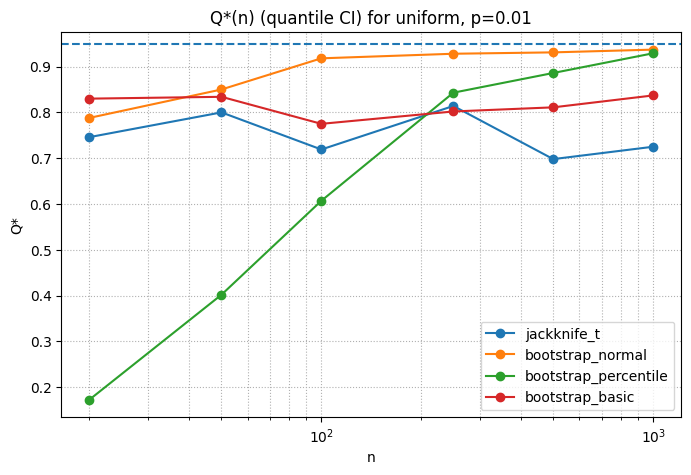

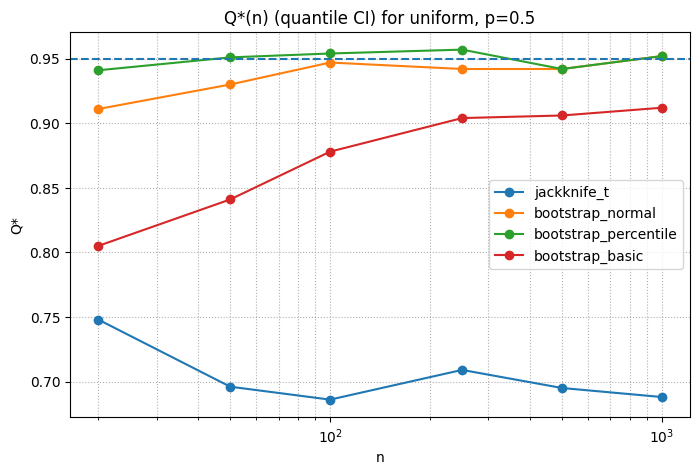

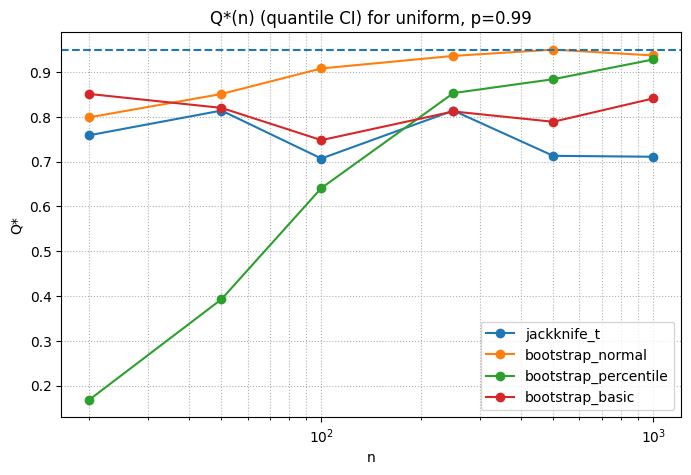

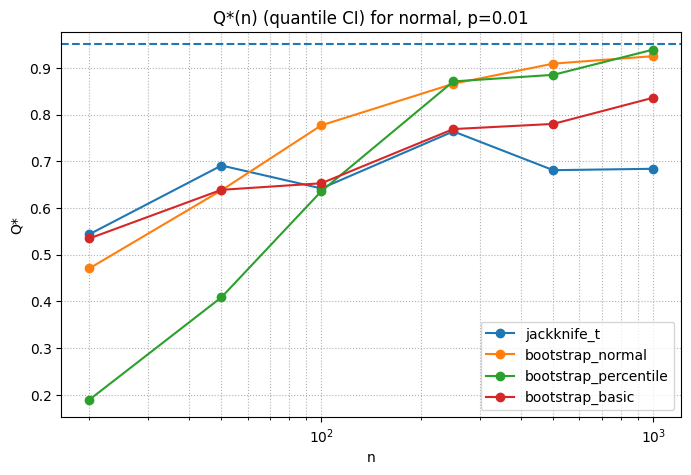

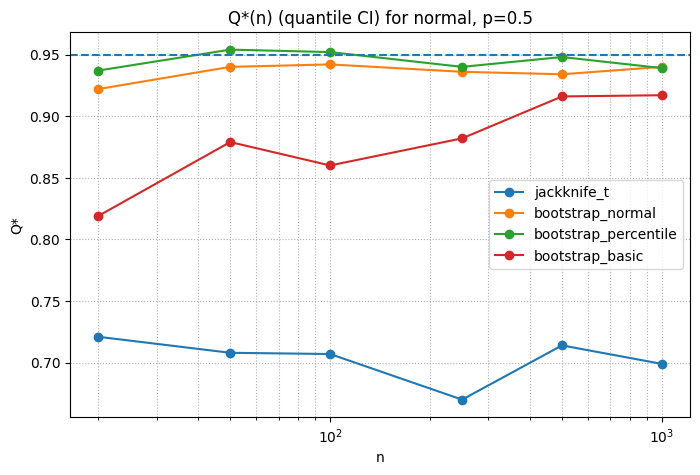

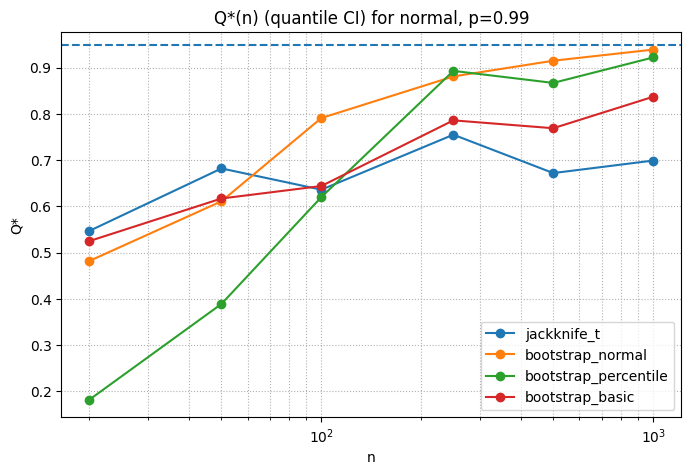

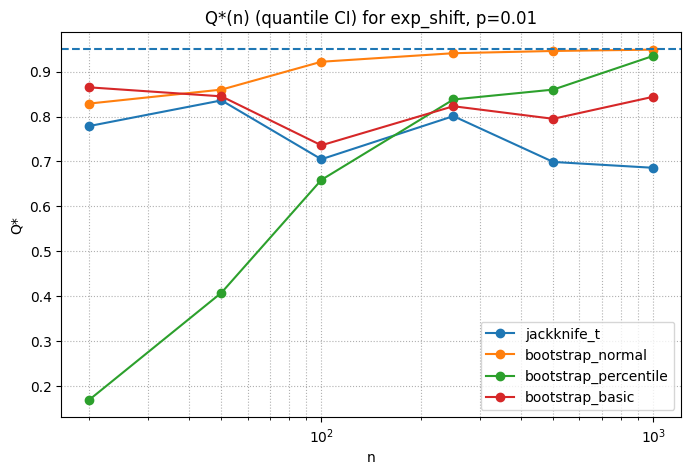

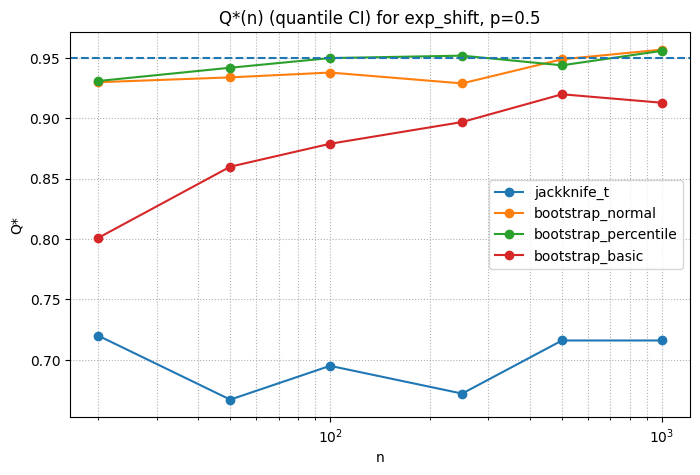

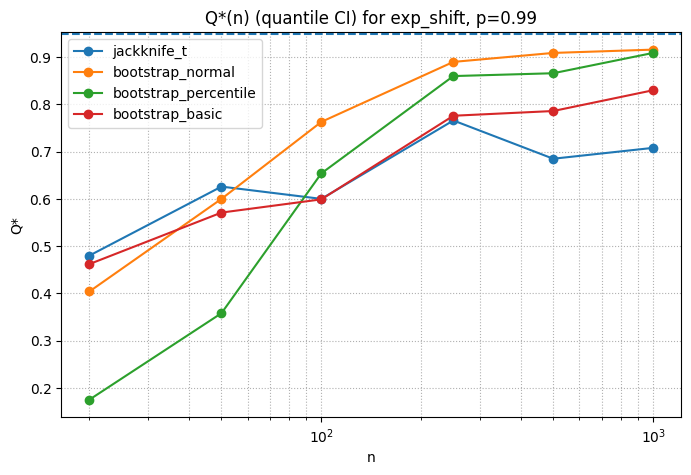

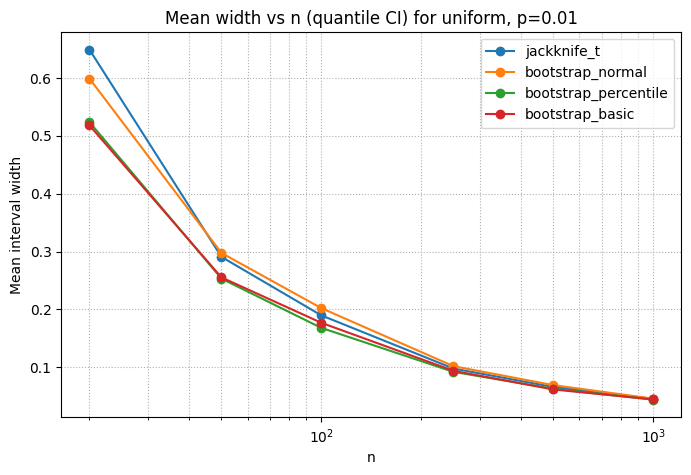

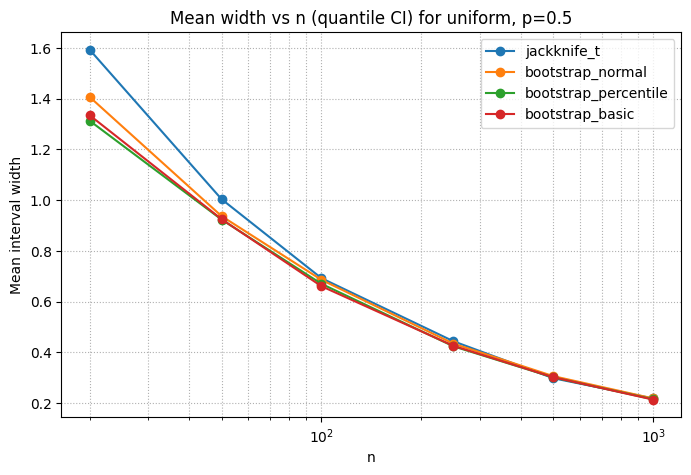

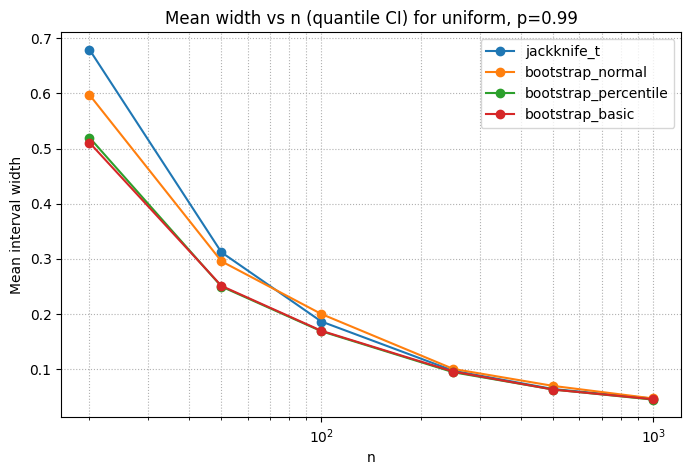

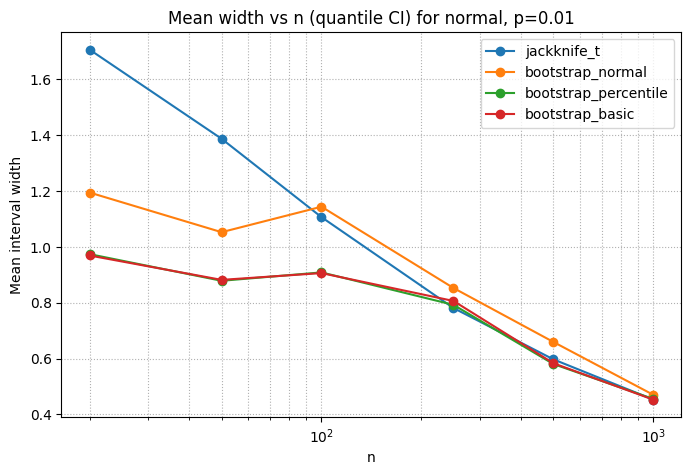

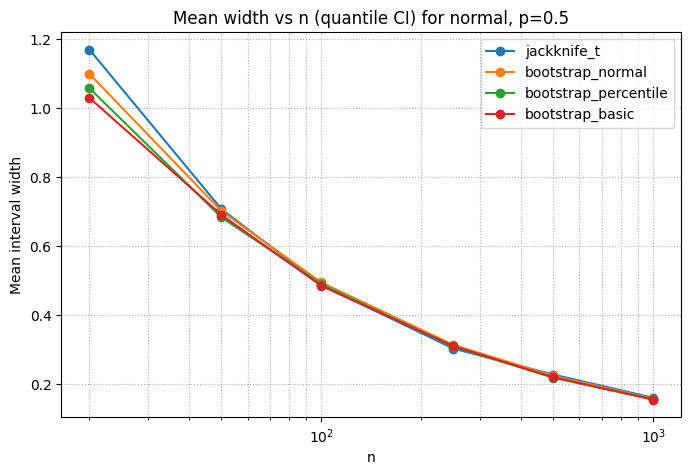

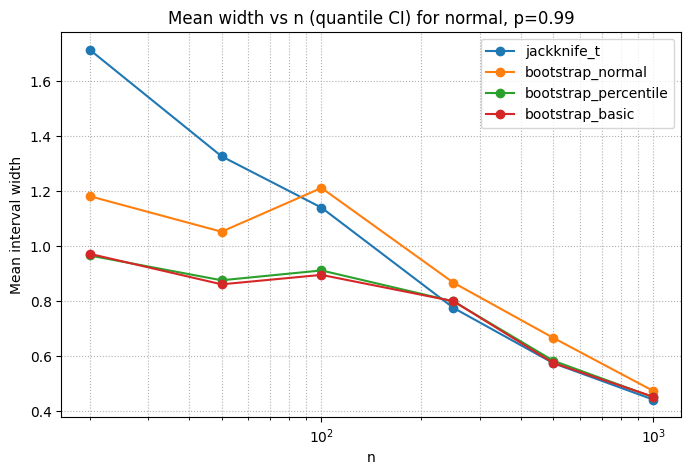

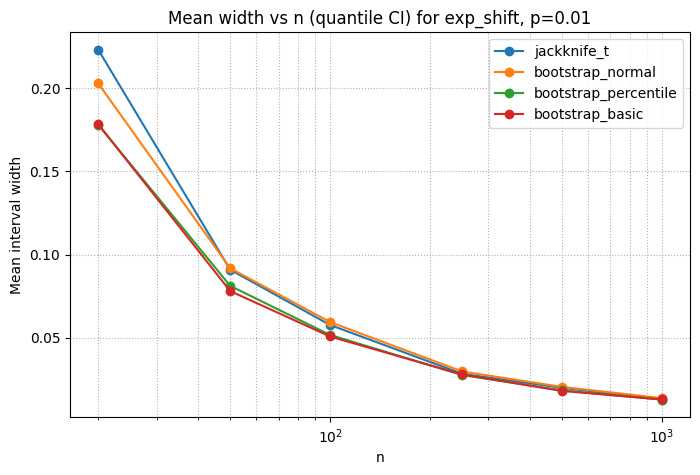

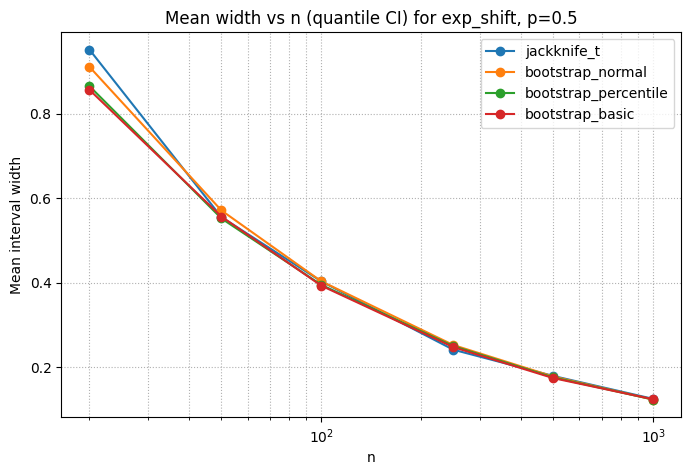

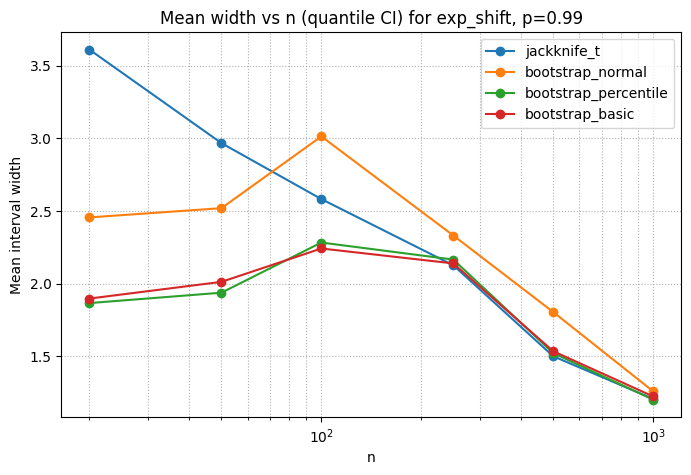

In [4]:
def plot_quantile_metric(df: pd.DataFrame, dist: str, p: float, y_col: str, title_prefix: str, y_label: str, add_ref: bool = False):
    sub = df[(df["distribution"] == dist) & (df["p"] == p)].copy()

    plt.figure(figsize=(8, 5))
    for method in ["jackknife_t", "bootstrap_normal", "bootstrap_percentile", "bootstrap_basic"]:
        s = sub[sub["method"] == method].sort_values("n")
        plt.plot(s["n"], s[y_col], marker="o", label=method)

    if add_ref:
        plt.axhline(0.95, linestyle="--")

    plt.xscale("log")
    plt.xlabel("n")
    plt.ylabel(y_label)
    plt.title(f"{title_prefix} for {dist}, p={p}")
    plt.legend()
    plt.grid(True, which="both", linestyle=":")
    plt.show()

# 3*3 графика для Q* и 3*3 для ширины: (распределение, p)
for dist in ["uniform", "normal", "exp_shift"]:
    for p in P_LIST:
        plot_quantile_metric(df_quant, dist, p, y_col="Q_star", title_prefix="Q*(n) (quantile CI)", y_label="Q*", add_ref=True)

for dist in ["uniform", "normal", "exp_shift"]:
    for p in P_LIST:
        plot_quantile_metric(df_quant, dist, p, y_col="mean_width", title_prefix="Mean width vs n (quantile CI)", y_label="Mean interval width", add_ref=False)

## Итоговые выводы по заданию 2: доверительные интервалы для квантилей (покрытие и ширина)

В задании исследовались доверительные интервалы для квантилей уровней  
$p \in \{0.01,\;0.5,\;0.99\}$, построенные методами jackknife и bootstrap  
(normal, percentile, basic) на распределениях:
равномерном, нормальном и экспоненциальном со сдвигом.

Анализ проводился по двум ключевым характеристикам:
- реальная доверительная вероятность $Q^*(n)$;
- средняя ширина доверительного интервала $\overline{W}(n)$.

### 1. Общие закономерности

1. Для всех распределений и всех квантилей при малых объёмах выборки ($n=20,50$) большинство методов не достигают номинального уровня $Q=0.95$, особенно для крайних квантилей.
2. При росте $n$ значения $Q^*(n)$ увеличиваются и для bootstrap-методов в ряде случаев приближаются к $0.95$, однако скорость сходимости сильно зависит от распределения и уровня квантиля.
3. Средняя ширина интервалов убывает с ростом $n$ примерно как $O(n^{-1/2})$ для всех методов и распределений.

### 2. Поведение jackknife-интервалов

Jackknife-интервалы для квантилей демонстрируют устойчивое и систематическое недопокрытие:
- для медианы ($p=0.5$) значения $Q^*$ часто находятся в диапазоне $0.65$–$0.75$ и практически не растут с увеличением $n$;
- для крайних квантилей ($p=0.01,\;0.99$) покрытие также существенно ниже номинального уровня.

При этом jackknife-интервалы, как правило, являются наиболее широкими, особенно при малых $n$.
Таким образом, jackknife одновременно оказывается и консервативным по ширине, и некорректным по покрытию, что делает его непригодным для построения доверительных интервалов квантилей в рассматриваемых условиях.

### 3. Bootstrap-percentile и bootstrap-basic

Bootstrap-percentile и bootstrap-basic дают наименьшие ширины интервалов почти во всех случаях.
Однако именно для этих методов наблюдается наиболее сильное недопокрытие:
- для крайних квантилей при малых и умеренных $n$ значения $Q^*$ могут быть значительно ниже $0.5$;
- особенно ярко этот эффект проявляется для асимметричного распределения exp_shift и для равномерного распределения у хвостовых квантилей.

Малая ширина интервалов достигается ценой существенной потери надёжности, поэтому эти методы нельзя считать универсальными.

### 4. Bootstrap-normal как компромиссный метод

Bootstrap-normal в среднем даёт интервалы:
- более широкие, чем percentile/basic;
- но заметно более устойчивые по покрытию.

Для медианы bootstrap-normal часто достигает $Q^*(n) \approx 0.95$ уже при умеренных $n$.
Для крайних квантилей покрытие bootstrap-normal остаётся заниженным при малых $n$, но растёт быстрее, чем у percentile/basic, и в большинстве случаев оказывается ближе к номинальному уровню.

Таким образом, bootstrap-normal демонстрирует наилучший баланс между шириной интервала и фактическим уровнем доверия.

### 5. Роль распределения и уровня квантиля

1. Крайние квантили ($p=0.01,\;0.99$) значительно сложнее для оценивания, чем медиана, что проявляется в:
   - более широких интервалах;
   - более медленной сходимости $Q^*(n)$ к $0.95$.
2. Асимметрия распределения (exp_shift) усиливает проблемы покрытия, особенно для нижнего квантиля $p=0.01$ и методов percentile/basic.
3. Для распределений с ограниченной поддержкой (uniform) bootstrap-percentile и bootstrap-basic оказываются особенно нестабильными для хвостовых квантилей.

### 6. Общий итог

Совместный анализ покрытия и ширины показывает, что:
- минимальная ширина доверительного интервала не гарантирует корректного доверительного уровня;
- jackknife не является надёжным инструментом для построения доверительных интервалов квантилей;
- bootstrap-percentile и bootstrap-basic склонны к систематическому недопокрытию;
- bootstrap-normal является наиболее устойчивым и сбалансированным методом среди рассмотренных.

Для практического построения доверительных интервалов квантилей в условиях конечных выборок предпочтение следует отдавать bootstrap-normal, особенно при наличии асимметрии распределения и при работе с хвостовыми квантилями.

# Задание 3. Неснижаемая погрешность границ доверительного интервала для матожидания

Пусть истинные значения $X_i$ недоступны, а наблюдаются величины с округлением/квантованием:
$$
Y_i = X_i + \varepsilon_i,
$$
где погрешность измерения/округления удовлетворяет
$$
\varepsilon_i \in \left[-\frac{\Delta}{2},\;\frac{\Delta}{2}\right],
\quad \Delta_i=\Delta=\text{const}.
$$

Естественная модель для округления предполагает равномерное распределение ошибки:
$$
\varepsilon_i \sim \mathrm{Unif}\left(-\frac{\Delta}{2},\;\frac{\Delta}{2}\right),
\quad \mathbb{E}\varepsilon_i = 0,\quad \mathrm{Var}(\varepsilon_i)=\frac{\Delta^2}{12}.
$$

Тогда дисперсия выборочного среднего из-за одной только погрешности измерения равна
$$
\mathrm{Var}(\bar\varepsilon)=\frac{1}{n}\mathrm{Var}(\varepsilon_1)=\frac{\Delta^2}{12n},
\quad \mathrm{SE}_\Delta(\bar X)=\frac{\Delta}{\sqrt{12n}}.
$$

Для доверительного интервала среднего вида
$$
\bar X \pm q_{1-\alpha/2}\cdot \mathrm{SE},
$$
неснижаемая добавка к полу-ширине интервала, обусловленная округлением, равна
$$
m_\Delta(n)=q_{1-\alpha/2}\cdot \frac{\Delta}{\sqrt{12n}}.
$$

Соответственно, неснижаемая добавка к полной ширине:
$$
W_\Delta(n)=2m_\Delta(n)=2q_{1-\alpha/2}\cdot \frac{\Delta}{\sqrt{12n}}.
$$

Цель: построить графики $W_\Delta(n)$ для нескольких значений $\Delta$ и наложить их на графики средних ширин доверительных интервалов для матожидания из предыдущего задания.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

Q = 0.95
alpha = 1 - Q
z = stats.norm.ppf(1 - alpha/2)

N_SIZES = [20, 50, 100, 250, 500, 1000]

# набор Δ для сравнения
DELTA_LIST = [0.01, 0.05, 0.1, 0.2]

def irreducible_width(n: int, Delta: float, z: float = z) -> float:
    # W_Δ(n) = 2 z * Δ / sqrt(12 n)
    return float(2 * z * Delta / np.sqrt(12 * n))

# таблица W_Δ(n) для всех Δ и n
rows = []
for Delta in DELTA_LIST:
    for n in N_SIZES:
        rows.append({"Delta": Delta, "n": n, "W_delta": irreducible_width(n, Delta)})
df_delta = pd.DataFrame(rows)
df_delta

,Delta,n,W_delta
0,0.01,20,0.002530
1,0.01,50,0.001600
2,0.01,100,0.001132
3,0.01,250,0.000716
4,0.01,500,0.000506
5,0.01,1000,0.000358
6,0.05,20,0.012652
7,0.05,50,0.008002
8,0.05,100,0.005658
9,0.05,250,0.003578


In [6]:
import numpy as np
import pandas as pd
from scipy import stats

# параметры
Q = 0.95
alpha = 1 - Q
N_REPS = 1000
N_SIZES = [20, 50, 100, 250, 500, 1000]

RNG = np.random.default_rng(2028)

# ---------- генераторы выборок ----------

def sample_uniform(n: int, rng: np.random.Generator) -> np.ndarray:
    a = -np.sqrt(3.0)
    b = np.sqrt(3.0)
    return rng.uniform(a, b, size=n)

def sample_normal(n: int, rng: np.random.Generator) -> np.ndarray:
    return rng.normal(0.0, 1.0, size=n)

def sample_exp_shift(n: int, rng: np.random.Generator, lam: float = 1.0, c: float = -1.0) -> np.ndarray:
    y = rng.exponential(scale=1.0 / lam, size=n)
    return y + c

DISTRIBUTIONS = {
    "uniform": sample_uniform,
    "normal": sample_normal,
    "exp_shift": sample_exp_shift,
}

# ---------- доверительные интервалы ----------

def asymptotic_interval(sample: np.ndarray, alpha: float = 0.05):
    n = len(sample)
    mean = sample.mean()
    std = sample.std(ddof=1)
    z = stats.norm.ppf(1 - alpha / 2)
    margin = z * std / np.sqrt(n)
    return mean - margin, mean + margin, 2 * margin

def student_interval(sample: np.ndarray, alpha: float = 0.05):
    n = len(sample)
    mean = sample.mean()
    std = sample.std(ddof=1)
    t = stats.t.ppf(1 - alpha / 2, df=n - 1)
    margin = t * std / np.sqrt(n)
    return mean - margin, mean + margin, 2 * margin

def hora_hora_interval(sample: np.ndarray, Q: float = 0.95):
    n = len(sample)
    mean = sample.mean()
    a = sample.min()
    b = sample.max()
    K = np.sqrt(-np.log((1 - Q) / 2) / (2 * n)) - 1 / (6 * n)
    lower = mean - (b - a) * K
    upper = mean + (b - a) * K
    return lower, upper, upper - lower

INTERVALS = {
    "asymptotic": lambda x: asymptotic_interval(x, alpha),
    "student": lambda x: student_interval(x, alpha),
    "hora_hora": lambda x: hora_hora_interval(x, Q),
}

# ---------- расчёт средней ширины ----------

records = []

for dist_name, sampler in DISTRIBUTIONS.items():
    for n in N_SIZES:
        for interval_name, interval_fn in INTERVALS.items():
            widths = np.empty(N_REPS)
            for i in range(N_REPS):
                x = sampler(n, RNG)
                _, _, w = interval_fn(x)
                widths[i] = w
            records.append({
                "distribution": dist_name,
                "n": n,
                "interval": interval_name,
                "mean_width": widths.mean(),
            })

df_width = pd.DataFrame(records).sort_values(
    ["distribution", "interval", "n"]
).reset_index(drop=True)

df_width

,distribution,n,interval,mean_width
0,exp_shift,20,asymptotic,0.841378
1,exp_shift,50,asymptotic,0.535835
2,exp_shift,100,asymptotic,0.385901
3,exp_shift,250,asymptotic,0.247021
4,exp_shift,500,asymptotic,0.174566
5,exp_shift,1000,asymptotic,0.123933
6,exp_shift,20,hora_hora,2.101005
7,exp_shift,50,hora_hora,1.718371
8,exp_shift,100,hora_hora,1.384353
9,exp_shift,250,hora_hora,1.035794


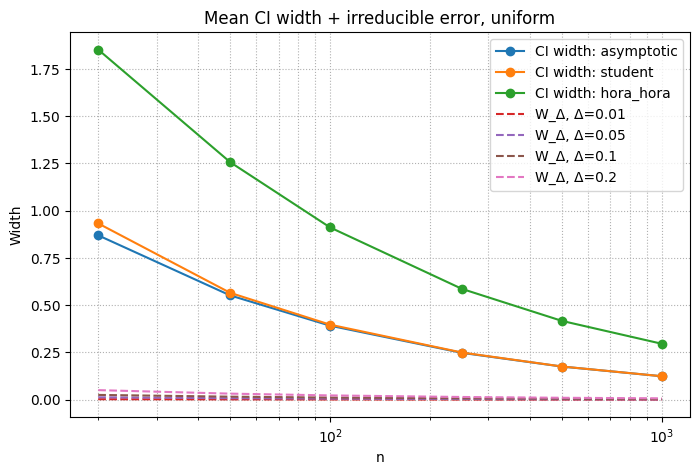

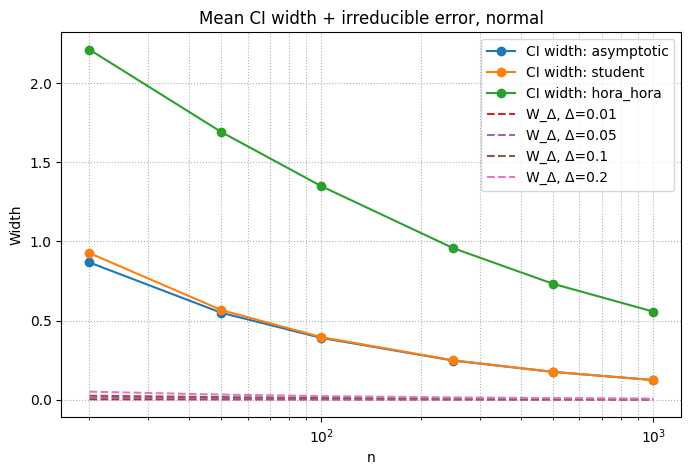

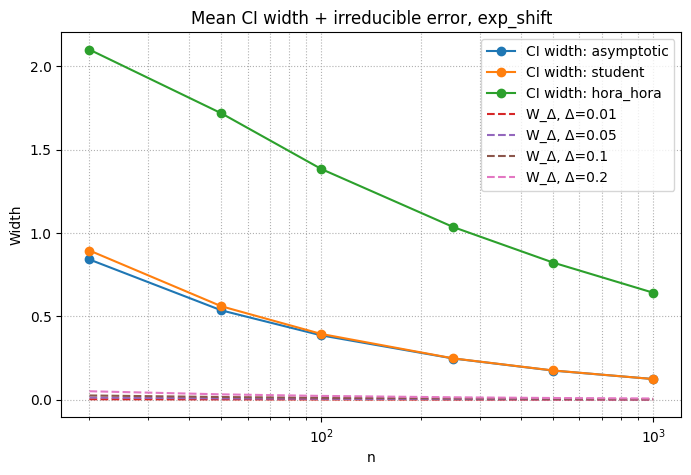

In [7]:
def plot_overlay_for_distribution(dist: str):
    sub = df_width[df_width["distribution"] == dist]

    plt.figure(figsize=(8, 5))

    # реальные доверительные интервалы для матожидания
    for interval in ["asymptotic", "student", "hora_hora"]:
        s = sub[sub["interval"] == interval].sort_values("n")
        plt.plot(
            s["n"],
            s["mean_width"],
            marker="o",
            label=f"CI width: {interval}"
        )

    # неснижаемая погрешность
    for Delta in DELTA_LIST:
        s2 = df_delta[df_delta["Delta"] == Delta].sort_values("n")
        plt.plot(
            s2["n"],
            s2["W_delta"],
            linestyle="--",
            label=f"W_Δ, Δ={Delta}"
        )

    plt.xscale("log")
    plt.xlabel("n")
    plt.ylabel("Width")
    plt.title(f"Mean CI width + irreducible error, {dist}")
    plt.grid(True, which="both", linestyle=":")
    plt.legend()
    plt.show()


for dist in ["uniform", "normal", "exp_shift"]:
    plot_overlay_for_distribution(dist)

## Выводы по заданию 3: неснижаемая погрешность доверительных интервалов для матожидания

В этом пункте рассматривалось влияние аддитивной погрешности измерения
$\Delta_i=\Delta=\mathrm{const}$ на ширину доверительных интервалов для математического ожидания.

Неснижаемая добавка к полной ширине доверительного интервала при уровне доверия $Q=0.95$
имеет вид
$$
W_\Delta(n)=2z_{1-\alpha/2}\cdot \frac{\Delta}{\sqrt{12n}},
\quad \alpha=1-Q,
$$
и была наложена на эмпирические средние ширины доверительных интервалов,
построенных по методам:
асимптотическому, Стьюдента и Хора–Хора.

### 1. Поведение неснижаемой погрешности

Для всех значений $\Delta$ и всех распределений наблюдается:
1. Убывание $W_\Delta(n)$ как $O(n^{-1/2})$ при росте объёма выборки.
2. Линейная зависимость величины неснижаемой погрешности от $\Delta$.
3. Независимость формы кривой $W_\Delta(n)$ от типа распределения.

Таким образом, вклад округления или измерительной погрешности принципиально не может быть устранён увеличением $n$ быстрее, чем основная статистическая погрешность среднего.

### 2. Сравнение с шириной доверительных интервалов

На всех трёх графиках (uniform, normal, exp_shift) видно, что:
- при рассматриваемых значениях $\Delta \le 0.2$ величина $W_\Delta(n)$ существенно меньше ширины доверительных интервалов для матожидания при всех $n$;
- даже для $n=1000$ вклад неснижаемой погрешности остаётся на порядок меньше ширины классических доверительных интервалов.

Это означает, что в данных условиях основным источником неопределённости остаётся стохастическая вариативность выборки, а не погрешность измерения.

### 3. Роль метода построения интервала

Метод Хора–Хора даёт существенно более широкие интервалы по сравнению с асимптотическим и t-интервалом.
В результате относительный вклад неснижаемой погрешности $W_\Delta(n)$ для интервала Хора–Хора оказывается ещё менее значимым.

Для асимптотического и t-интервалов, которые имеют близкие ширины, влияние неснижаемой погрешности также остаётся вторичным при выбранных значениях $\Delta$.

### 4. Интерпретация в практических терминах

Неснижаемая погрешность задаёт нижнюю границу точности оценивания математического ожидания при фиксированном уровне доверия.
Однако при умеренных значениях $\Delta$ эта граница может быть существенно ниже фактической ширины доверительного интервала,
что делает её практически незаметной на фоне статистической неопределённости.

Только при существенно больших значениях $\Delta$ или при экстремально больших $n$
неснижаемая погрешность стала бы доминирующим фактором, определяющим ширину доверительного интервала.

### 5. Итог

Для всех рассмотренных распределений и объёмов выборки в данном эксперименте
неснижаемая погрешность не является ограничивающим фактором точности доверительных интервалов для матожидания.
Основной вклад в ширину интервала вносит именно стохастическая вариативность данных и выбор используемого метода построения доверительного интервала.
